## Labo 2 - Détection d'anomalies - Outliers
### Pierric Ripoll & Aurélien Bloch

In [131]:
pip install pandas scipy matplotlib

11284.01s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
from scipy.io import arff
from matplotlib import pyplot as plt
import numpy as np
from sklearn import svm
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.neighbors import LocalOutlierFactor

def load_data(path):
    datapath = 'data/'
    file = arff.loadarff(datapath + path)
    return df

pd.set_option('future.no_silent_downcasting', True)

def applyLofAndScore(df, lof):
    df_attr = df.drop(columns=['id', 'outlier'])
    predict = pd.DataFrame(lof.fit_predict(df_attr))
    truth = df['outlier'].replace({b'yes': -1, b'no': 1}).infer_objects(copy=False)
    return {'predict': predict, 'truth': truth}

def computeAllLOF(df):
    nNeighbors = (1, 2, 5, 10, 20, 50)
    contams = ( 0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5)

    results = []

    for n in nNeighbors:
        for c in contams:
            tup = applyLofAndScore(df, LocalOutlierFactor(n_neighbors=n, contamination=c))
            results.append({'n_neighbors': n, 'contamination': c,
                            'score': 100 * f1_score(tup['truth'], tup['predict'])})

    results = pd.DataFrame(results)

    return results

def printAllLOF(df):

    df = df.pivot(index='n_neighbors', columns='contamination', values='score')

    # Create the heatmap
    plt.figure(figsize=(11, 6))
    plt.imshow(df, cmap='viridis', aspect='auto')

    # Add annotations
    tresh = df.mean().mean()
    for i in range(len(df)):
        for j in range(len(df.columns)):
            plt.text(j, i, f"{df.iloc[i, j]:.6f}",
                    ha='center', va='center', color='white' if df.iloc[i, j] < tresh else 'black')

    # Add labels and title
    plt.xticks(np.arange(len(df.columns)), df.columns, rotation=45)
    plt.yticks(np.arange(len(df)), df.index)
    plt.xlabel('Contamination')
    plt.ylabel('n_neighbors')
    plt.title('Scores by n_neighbors and contamination')

    # Show the plot
    # plt.tight_layout()
    plt.show()

def printConfusionMatrix(truth, predict):
    conf_matrix = confusion_matrix(truth, predict)

    # plot
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')

    # Add labels to the plot
    classes = ['Outlier (-1)', 'Inlier (1)']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Add text annotations
    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, conf_matrix[i, j],
                    horizontalalignment="center",
                    color="white" if conf_matrix[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

===== Glass dataset ======


/home/wslrip/pcd/PCDLabs/Labo2/.venv/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(
/home/wslrip/pcd/PCDLabs/Labo2/.venv/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(
/home/wslrip/pcd/PCDLabs/Labo2/.venv/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(
/home/wslrip/pcd/PCDLabs/Labo2/.venv/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(
/home/wslrip/pcd/PCDLabs/Labo2/.venv/lib/python3

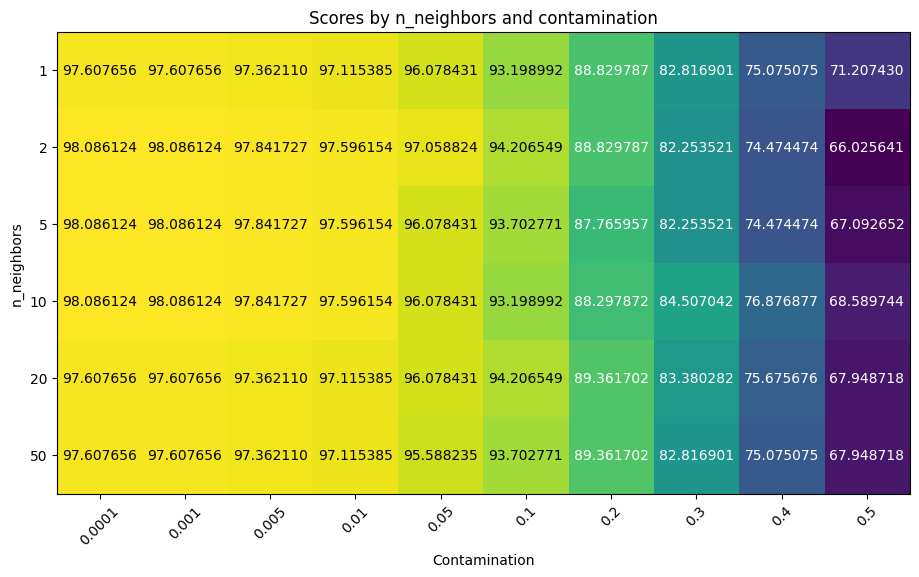

best LOF parameters for Glass dataset: n_neighbors = 2.0, contamination = 0.0001
confusion matrix with the best parameters: 


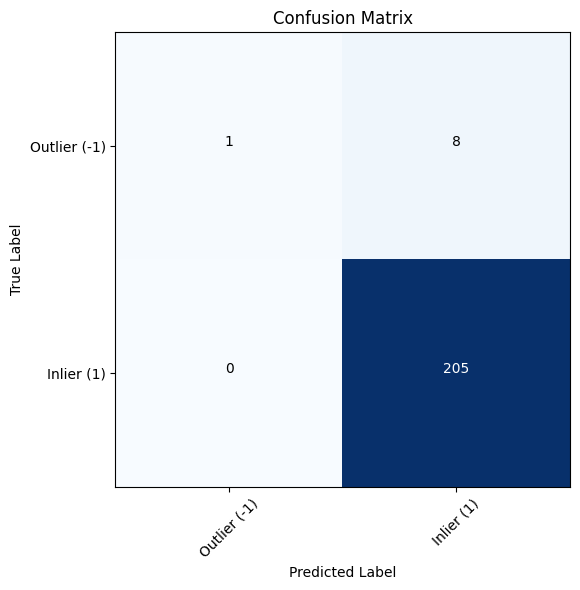

===== Ionosphere dataset ======


/home/wslrip/pcd/PCDLabs/Labo2/.venv/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(
/home/wslrip/pcd/PCDLabs/Labo2/.venv/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(
/home/wslrip/pcd/PCDLabs/Labo2/.venv/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(
/home/wslrip/pcd/PCDLabs/Labo2/.venv/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(
/home/wslrip/pcd/PCDLabs/Labo2/.venv/lib/python3

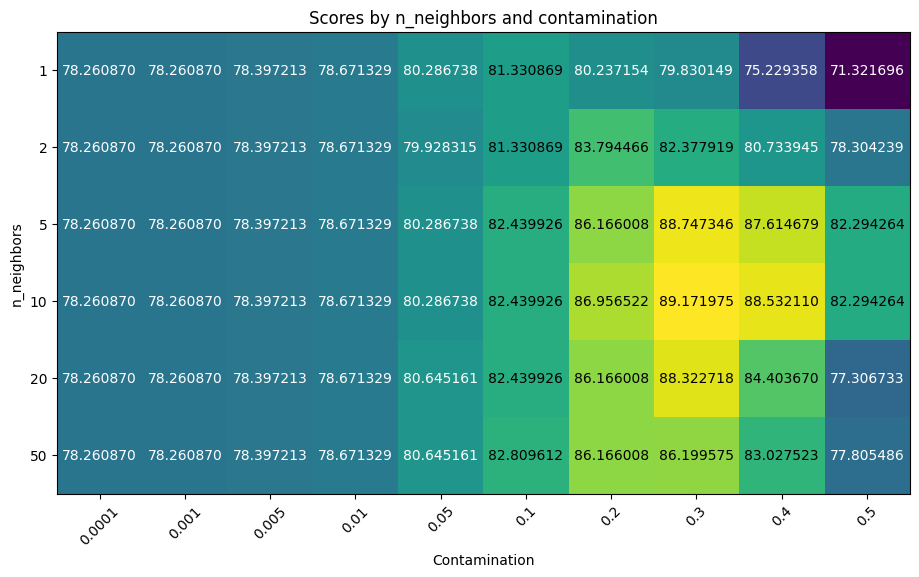

best LOF parameters for Ionosphere dataset: n_neighbors = 10.0, contamination = 0.3
confusion matrix with the best parameters: 


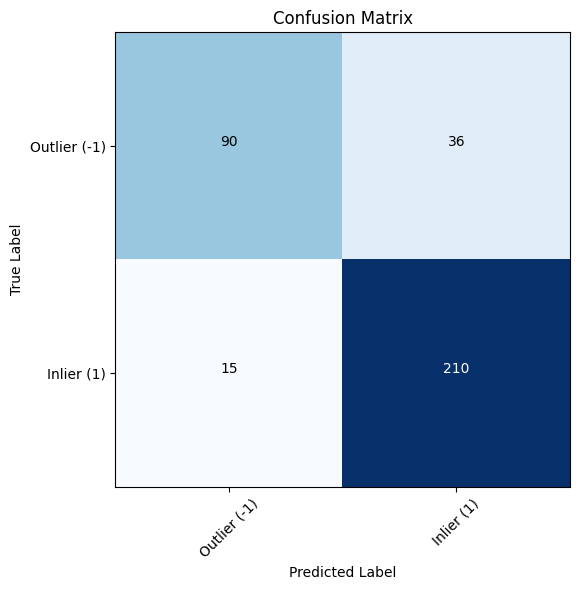

In [133]:

datasets = ({'name':'Glass', 'path':'Glass_withoutdupl_norm.arff'},
 # {'name':'ALOI', 'path':'ALOI_withoutdupl_norm.arff'},
 {'name':'Ionosphere', 'path':'Ionosphere_withoutdupl_norm.arff'})

for d in datasets:
    print(f'===== {d['name']} dataset ======')
    data = load_data(d['path'])
    dataLOF = computeAllLOF(data)
    printAllLOF(dataLOF)

    bestDataLOF = dataLOF.loc[dataLOF['score'].idxmax()]

    print(f"best LOF parameters for {d['name']} dataset: n_neighbors = {bestDataLOF['n_neighbors']}, contamination = {bestDataLOF['contamination']}")
    print("confusion matrix with the best parameters: ")
    results = applyLofAndScore(data, LocalOutlierFactor(n_neighbors=int(bestDataLOF['n_neighbors']), contamination=bestDataLOF['contamination']))
    printConfusionMatrix(predict=results['predict'], truth=results['truth'])